# Преображенская С.А. - 11.21

In [1]:
!pip install -U torch torchvision;

     |████████████████████████████████| 881.9 MB 13 kB/s 
     |████████████████████████████████| 23.3 MB 50.2 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1+cpu
    Uninstalling torch-1.9.1+cpu:
      Successfully uninstalled torch-1.9.1+cpu
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1+cpu
    Uninstalling torchvision-0.10.1+cpu:
      Successfully uninstalled torchvision-0.10.1+cpu
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.1 requires torch==1.9.1, but you have torch 1.10.0 which is incompatible.
torchaudio 0.9.1 requires torch==1.9.1, but you have torch 1.10.0 which is incompatible.
allennlp 2.7.0 requires torch<1.10.0,>=1.6.0, but you have torch 1.10.0 which is incompatible.
allennlp 2.7.0 requires torchvision<0.11.0,>=0.8.1, but you have torchvision 0.11.1 whic

## 0. Загружаем библиотеки, инициализируем случайные числа, задаем константы

In [2]:
import os
from tqdm.autonotebook import tqdm, trange

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from pathlib import Path
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
import pickle
from PIL import Image

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
import random 
SEED = 7

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
TRAIN_DIR = Path('../input/journey-springfield/train')
TEST_DIR = Path('../input/journey-springfield/testset')

#я работаю в kaggle-ноутбуке

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
CUDA_LAUNCH_BLOCKING=1
BATCH_SIZE=128

print(DEVICE)

cpu


## 1. Создаем класс для датасета. Добавила в него аугментации для режима 'train'.

In [5]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.5),])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        if self.mode == 'train':
          x = data_transforms(x)
        else:
          x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

## 2. Загрузка данных. Проведена балансировка данных (код украден из комментов к задаче). В классах, в которых количество картинок меньше 100, картинки просто дублируются до 100. При этом аугментация должна помочь с переобучением.

In [6]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [7]:
n_classes = len(np.unique(train_val_labels))
n_classes

42

In [8]:
train_labels = [path.parent.name for path in train_files] # классы train
val_labels = [path.parent.name for path in val_files]     # классы val

In [9]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

def print_dct(dct_simpsons):
    for key in dct_simpsons:
        print(f"{key}\t{dct_simpsons[key]}")

In [10]:
dct_path_train = create_dct_path_labels(train_files, train_labels)

In [11]:
# Дополним картинки классов у которых менее 100 картинок, до 100 картинок в классе
for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])

# Проверим что получилось 
for person in dct_path_train:
    print(f"{person}\t{len(dct_path_train[person])}")

abraham_grampa_simpson	685
agnes_skinner	100
apu_nahasapeemapetilon	467
barney_gumble	100
bart_simpson	1006
carl_carlson	100
charles_montgomery_burns	895
chief_wiggum	739
cletus_spuckler	100
comic_book_guy	352
disco_stu	100
edna_krabappel	343
fat_tony	100
gil	100
groundskeeper_willie	100
homer_simpson	1684
kent_brockman	373
krusty_the_clown	904
lenny_leonard	233
lionel_hutz	100
lisa_simpson	1015
maggie_simpson	100
marge_simpson	968
martin_prince	100
mayor_quimby	185
milhouse_van_houten	809
miss_hoover	100
moe_szyslak	1089
ned_flanders	1090
nelson_muntz	269
otto_mann	100
patty_bouvier	100
principal_skinner	895
professor_john_frink	100
rainier_wolfcastle	100
ralph_wiggum	100
selma_bouvier	100
sideshow_bob	658
sideshow_mel	100
snake_jailbird	100
troy_mcclure	100
waylon_smithers	136


In [12]:
def create_dct_from_labels(train_val_labels):

    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons.update({label_i:train_val_labels.count(label_i)})

    return dct_simpsons

new_train_files = []

for person in dct_path_train:
    new_train_files.extend(dct_path_train[person])

new_train_label = [path.parent.name for path in new_train_files]

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')
new_train_dataset = SimpsonsDataset(new_train_files, mode='train')

## 4. Функции для обучения модели (оставлены без изменений)

In [14]:
def fit_epoch(model, train_dataloader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_dataloader:
        inputs = inputs.to(DEVICE) #перенос тензоров на видеокарту
        labels = labels.to(DEVICE)
        optimizer.zero_grad() #обнуляем градиенты, чтобы они не накапливались

        outputs = model(inputs) #прогоняем данные из трейнлоадера чеез нашу сеть (модель). интересно, почему не model.forward(inputs)?
        loss = criterion(outputs, labels) #считаем лосс
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1) #все, что больше 1, приводим к 1
        running_loss += loss.item() * inputs.size(0) #непонятно, как работает .size(0)
        running_corrects += torch.sum(preds == labels.data) #если предсказание совпадает с ответом, увеличиваем на 1 running_corrects
        processed_data += inputs.size(0) 
              
    train_loss = running_loss / processed_data #потери на трейне
    train_acc = running_corrects.cpu().numpy() / processed_data #точность на трейне
    return train_loss, train_acc

In [15]:
def eval_epoch(model, val_dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_dataloader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [16]:
def train(train_files, val_files, model, epochs, batch_size):
    train_dataloader = DataLoader(new_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
       
        opt = torch.optim.Adam(model.parameters(), lr=3e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_dataloader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_dataloader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

## 5. Transfer learning с частичной заморозкой слоев на сети AlexNet

In [17]:
model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [18]:
layers_to_unfreeze = 5

for param in model.features[:-layers_to_unfreeze].parameters():
    param.requires_grad = False
    
num_features = 9216
model.classifier = nn.Linear(9216, n_classes)

model = model.to(DEVICE)


In [19]:
history = train(new_train_dataset, val_dataset, model=model, epochs=8, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 1.3788368365192385

Epoch 001 train_loss: 1.3788     val_loss 0.6213 train_acc 0.6514 val_acc 0.8363
loss 0.38073932378205294

Epoch 002 train_loss: 0.3807     val_loss 0.4378 train_acc 0.8986 val_acc 0.8888
loss 0.21098788694962836

Epoch 003 train_loss: 0.2110     val_loss 0.4084 train_acc 0.9460 val_acc 0.9016
loss 0.1336052270886742

Epoch 004 train_loss: 0.1336     val_loss 0.4112 train_acc 0.9656 val_acc 0.9020
loss 0.08627071164440353

Epoch 005 train_loss: 0.0863     val_loss 0.4324 train_acc 0.9785 val_acc 0.9104
loss 0.06520117359441496

Epoch 006 train_loss: 0.0652     val_loss 0.4631 train_acc 0.9842 val_acc 0.9079
loss 0.04433789445309464

Epoch 007 train_loss: 0.0443     val_loss 0.5089 train_acc 0.9896 val_acc 0.9089
loss 0.035317606751683835

Epoch 008 train_loss: 0.0353     val_loss 0.4662 train_acc 0.9909 val_acc 0.9089


In [20]:
torch.save(model.state_dict(), 'Simpsons_AlexNet.pth')
model.load_state_dict(torch.load('Simpsons_AlexNet.pth'))

<All keys matched successfully>

In [21]:
loss, acc, val_loss, val_acc = zip(*history)

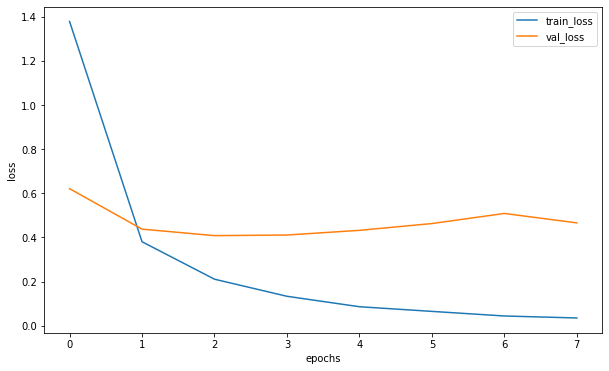

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

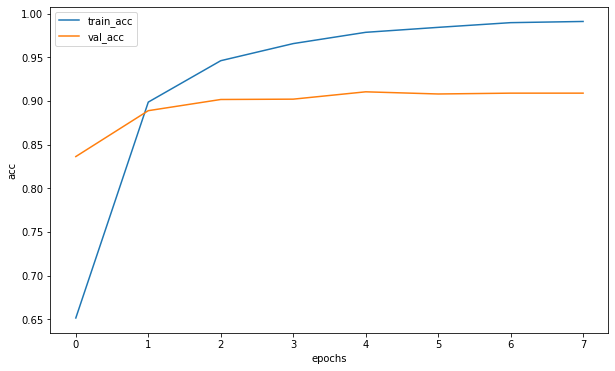

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

## 6. Получение предсказания

In [24]:
def predict(model, test_loader):
    with torch.no_grad(): #без градиентов
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [25]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [26]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [27]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader) #матрица с вероятностями для каждого класса

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1)) #вектор в наибольшими вероятностями
test_filenames = [path.name for path in test_dataset.files]

In [28]:
# ДОБАВЛЕНО: создание сабмита
import pandas as pd
df = pd.DataFrame()
df['Id'] = test_filenames
df['Expected'] = preds
df.to_csv(Path('./submission_.csv'), index=False)
# файл появится у вас на гугл диске

# Результат на кагле 0.96599

Также были проведены эксперименты:
1. Простая сеть CNN с использованием BatchNorm, Dropout. Результат 0.92561
2. AlexNet с заморозкой всех слоев. Результат 0.83740
3. Inception с заморозкой всех слоев. Результат 0.65143
4. Inception без заморозки слоев. Результат 0.95430